### **COLAB INSTALLATIONS AND DRIVE MOUNTING**

In [8]:
!pip install catboost 

     |████████████████████████████████| 66.1MB 46kB/s 


In [4]:
from google.colab import drive
drive.mount("/content/drive/")


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
%cd "drive/My Drive/"

/content/drive/My Drive


### **IMPORT NECESSARY LIBRARIES**

This solution to the Expresso Churn prediction challenge is a stack of three models(CatBoost, XGBoost and LGBM).

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import catboost as cat_
import seaborn as sns
import lightgbm as lgb

### **HELPER FUNCTION**

This is where the cross validation loop and other processes are built for easy training and stacking throughout our workflow...  In this class, a variable "val_p" has been created. This is where all the predictions based on the validation set from each cross validation loop is stored, resulting to us having predictions based on the whole training data itself. Also, another 
variable "test_p" is where the test set predictions are stored.

In [10]:
class func() :   
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost', 'xgboost', 'lgbm'), 'Incorrect model_type'
    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,
                           verbose=50,use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:,1]
            x_train_predict = self.model.predict_proba(X_train)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration = self.model.best_iteration_)[:,1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration = self.model.best_iteration_)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration = self.model.best_iteration_)[:,1]
            return x_test_predict, x_train_predict


        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 5
        kf = StratifiedKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'catboost': x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost': x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm': x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)

            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_test, x_test_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot:
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_,self.train.columns)), columns=['Value','Feature'])
            plt.figure(figsize=(30,25))
            sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p/splits, self.model

### **DATA IMPORT AND CLEANING**

In [12]:
train = pd.read_csv('expersso-churn-prediction/data/AIMS_Train.csv')
test = pd.read_csv('expersso-churn-prediction/data/AIMS_Test.csv')
submission = pd.read_csv('expersso-churn-prediction/data/AIMS_SampleSubmission.csv')
VariableDefinitions = pd.read_csv('expersso-churn-prediction/data/VariableDefinitions.csv')

In [13]:
train.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,51d5367a58953904c14238c4dd7393f5c4fd0a88,MATAM,K > 24 month,1000.0,1.0,990.0,330.0,1.0,97.0,1.0,NaN,NaN,NaN,NaN,NO,22,"Data:1000F=2GB,30d",1.0,0
1,3322a4900689f7f3cb14b8f9ea00778853f02d75,DIOURBEL,K > 24 month,NaN,NaN,NaN,NaN,NaN,223.0,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,0
2,3b00ec4bfcc855c6f39b14a722e47ec6d15607e7,DAKAR,K > 24 month,700.0,5.0,1010.0,337.0,7.0,566.0,1.0,3.0,15.0,0.0,NaN,NO,8,"Data: 100 F=40MB,24H",3.0,0
3,98c44b62c33c6a1d9dbcf5e918868419f249c4a8,LOUGA,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,0
4,18bd8c41ecb503a2d9137e3f70bc1caf146a266d,NaN,K > 24 month,3000.0,3.0,2995.0,998.0,3.0,NaN,NaN,33.0,NaN,NaN,NaN,NO,9,NaN,NaN,0


In [14]:
test.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,c1b31e7cef249f2b777d934886b787a433029263,DAKAR,K > 24 month,10600.0,18.0,11099.0,3700.0,22.0,4004.0,60.0,123.0,19.0,NaN,NaN,NO,61,All-net 500F=2000F;5d,9.0
1,c205f3aff8486b0bed1051f3bf25fe04df7f671e,KAOLACK,K > 24 month,NaN,NaN,NaN,NaN,NaN,0.0,7.0,NaN,NaN,NaN,NaN,NO,6,NaN,NaN
2,d743faaf50bbc43e02a08a2c2f4326f6d368fb25,THIES,K > 24 month,17900.0,36.0,18405.0,6135.0,44.0,0.0,446.0,50.0,28.0,2.0,NaN,NO,62,On-net 1000F=10MilF;10d,9.0
3,c4e45ed21d5e2f64146b95fecbbb6b24740f803c,DAKAR,K > 24 month,10000.0,10.0,10001.0,3334.0,27.0,NaN,0.0,93.0,8.0,NaN,NaN,NO,45,All-net 500F=2000F;5d,12.0
4,96c6a822243654ae1fe5f5f887089681f806cb46,THIES,K > 24 month,500.0,1.0,500.0,167.0,1.0,NaN,8.0,14.0,NaN,NaN,NaN,NO,8,All-net 500F=2000F;5d,1.0


In [15]:
submission.head()

,user_id,CHURN
0,c1b31e7cef249f2b777d934886b787a433029263,0
1,c205f3aff8486b0bed1051f3bf25fe04df7f671e,0
2,d743faaf50bbc43e02a08a2c2f4326f6d368fb25,0
3,c4e45ed21d5e2f64146b95fecbbb6b24740f803c,0
4,96c6a822243654ae1fe5f5f887089681f806cb46,0


In [16]:
VariableDefinitions.dropna()[['Variable Definitions','Unnamed: 2']]

,Variable Definitions,Unnamed: 2
3,REGION,the location of each client
4,TENURE,duration in the network
5,MONTANT,top-up amount
6,FREQUENCE_RECH,number of times the customer refilled
7,REVENUE,monthly income of each client
8,ARPU_SEGMENT,income over 90 days / 3
9,FREQUENCE,number of times the client has made an income
10,DATA_VOLUME,number of connections
11,ON_NET,inter expresso call
12,ORANGE,call to orange


In [17]:
print(train.MRG.value_counts(dropna = False), 'Train length:', len(train), '\n')
print(test.MRG.value_counts(dropna = False), 'Test length:', len(test))

NO    646214
Name: MRG, dtype: int64 Train length: 646214 

NO    114038
Name: MRG, dtype: int64 Test length: 114038


From the cell above, it is quite obvious that our "MRG" column consists of only the value "NO" throughout the data set. It's best to remove such as it wouldn't introduce any information to our model.

In [18]:
train.drop(['user_id', 'MRG',], 1, inplace = True)
test.drop(['user_id', 'MRG',], 1, inplace = True)

### **DATA ENGINEERING**

In [19]:
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)

In [20]:
data.head()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,MATAM,K > 24 month,1000.0,1.0,990.0,330.0,1.0,97.0,1.0,NaN,NaN,NaN,NaN,22,"Data:1000F=2GB,30d",1.0,0.0
1,DIOURBEL,K > 24 month,NaN,NaN,NaN,NaN,NaN,223.0,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,0.0
2,DAKAR,K > 24 month,700.0,5.0,1010.0,337.0,7.0,566.0,1.0,3.0,15.0,0.0,NaN,8,"Data: 100 F=40MB,24H",3.0,0.0
3,LOUGA,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,0.0
4,NaN,K > 24 month,3000.0,3.0,2995.0,998.0,3.0,NaN,NaN,33.0,NaN,NaN,NaN,9,NaN,NaN,0.0


In [21]:
data['REVENUE-MONTANT'] = data['REVENUE'] - data['MONTANT']
data['REVENUE/MONTANT'] = data['REVENUE'] / data['MONTANT']

In [22]:
data['TENURE'] = data['TENURE'].map({'K > 24 month': 24, 'I 18-21 month': 18, 'H 15-18 month': 15, 'G 12-15 month':12,
                                             'J 21-24 month': 21, 'F 9-12': 9, 'E 6-9 month':6, 'D 3-6 month':3})

In [23]:
#RETURN THE AVERAGE OF THE MONTH/TENURE BOUNDARIES
data['TENURE_avg'] = data['TENURE'].map({'K > 24 month': (24+27)/2, 'I 18-21 month':(18+21)/2 , 'H 15-18 month': (15+18)/2, 'G 12-15 month':(12+15)/2,
                                             'J 21-24 month': (21+24)/2, 'F 9-12': (9+12)/2, 'E 6-9 month':(6+9)/2, 'D 3-6 month':(3+6)/2})

In [24]:
data['TENURE/FREQUENCE_RECH'] = data['TENURE_avg'] / data['FREQUENCE_RECH']
data['TENURE/REGULARITY'] = data['TENURE_avg'] / data['REGULARITY']

During the competition, the REGION column seemed to add a lot of importance to my model and even grouping any other column based on "REGION" also added more value to my cross validation mean accuracy, I decided to group all columns based on "REGION".

In [25]:
region = data.groupby('REGION').mean()
region.drop('CHURN', 1, inplace = True)
cols = []
for i in region.columns:
    if i != 'REGION':
        region[i+'_reg_mean_all'] = region[i]
        region.drop(i, 1, inplace = True)
        cols.append(i+'_reg_mean_all')

data = pd.merge(data, region, on='REGION', how = 'left')
for col in cols: data[col+'_freq'] = data[col].map(data[col].value_counts().to_dict())/len(data)

In [26]:
data['freq*montant'] = data['FREQUENCE'] * data['MONTANT']
data['freq*rech'] = data['FREQUENCE'] * data['FREQUENCE_RECH']
data['freq*revenue'] = data['FREQUENCE'] * data['REVENUE']
data['freq*segment'] = data['FREQUENCE'] * data['ARPU_SEGMENT']

data['freq/montant'] =  data['MONTANT']/ data['FREQUENCE']
data['freq/rech'] = data['FREQUENCE'] / data['FREQUENCE_RECH']
data['freq/revenue'] = data['FREQUENCE'] / data['REVENUE']
data['freq/segment'] = data['FREQUENCE'] / data['ARPU_SEGMENT']

In [27]:
data['data/reg'] = data['DATA_VOLUME'] / data['REGULARITY']
data['net/reg'] = data['ON_NET'] / data['REGULARITY']
data['montant-rech/freq'] = (data['MONTANT'] - data['FREQUENCE_RECH']) / data['FREQUENCE']
data['segment/reg'] = data['ARPU_SEGMENT'] / data['REGULARITY']

In [28]:
data['reg_log'] = np.log1p(data['REGULARITY'])
data['rech_log'] = np.log1p(data['FREQUENCE_RECH'])
data['data_log'] = np.log1p(data['DATA_VOLUME'])
data['montant_log'] = np.log1p(data['MONTANT'])
data['rev_log'] = np.log1p(data['REVENUE'])
data['freq_log'] = np.log1p(data['FREQUENCE'])

In [29]:
data['reglog-montlog'] = data['reg_log'] - data['montant_log']
data['revlog/montlog'] = data['REVENUE'] / data['montant_log']
data['tenure/rechlog'] = data['TENURE_avg'] / data['rech_log']
data['reglog-datalog'] = data['reg_log'] - data['data_log']

In [30]:
drop = ['REGION', 'TOP_PACK']
data.drop(drop, 1, inplace = True)

Extract training data, test data and target

In [31]:
train = data[:ntrain].copy()
#train.drop_duplicates(inplace = True, ignore_index=True)
target = train.CHURN.copy()
train.drop('CHURN', axis=1, inplace=True)

test = data[ntrain:].copy()
test.drop('CHURN', axis=1, inplace=True)
test = test.reset_index(drop=True)

### **MODEL 1 - CATBOOST**

The CATBOOST and XGBOOST models were trained on GPU(Google Colab) in order to save time. To train on CPU, you would have to remove the **task_type** and **devices** parameters.

================================Fold1====================================
0:	learn: 0.9252008	test: 0.9245710	best: 0.9245710 (0)	total: 29.6ms	remaining: 4m 56s
50:	learn: 0.9302114	test: 0.9296253	best: 0.9296253 (50)	total: 1.1s	remaining: 3m 35s
100:	learn: 0.9307405	test: 0.9300932	best: 0.9300932 (100)	total: 2.11s	remaining: 3m 27s
150:	learn: 0.9310283	test: 0.9303011	best: 0.9303014 (149)	total: 3.11s	remaining: 3m 22s
200:	learn: 0.9312025	test: 0.9304324	best: 0.9304324 (200)	total: 4.11s	remaining: 3m 20s
250:	learn: 0.9313264	test: 0.9305071	best: 0.9305086 (248)	total: 5.09s	remaining: 3m 17s
300:	learn: 0.9314171	test: 0.9305539	best: 0.9305539 (299)	total: 6.05s	remaining: 3m 14s
350:	learn: 0.9315111	test: 0.9306116	best: 0.9306116 (349)	total: 7.03s	remaining: 3m 13s
400:	learn: 0.9315830	test: 0.9306461	best: 0.9306461 (400)	total: 8.02s	remaining: 3m 11s
450:	learn: 0.9316617	test: 0.9306737	best: 0.9306737 (450)	total: 9.05s	remaining: 3m 11s
500:	learn: 0.9317367	

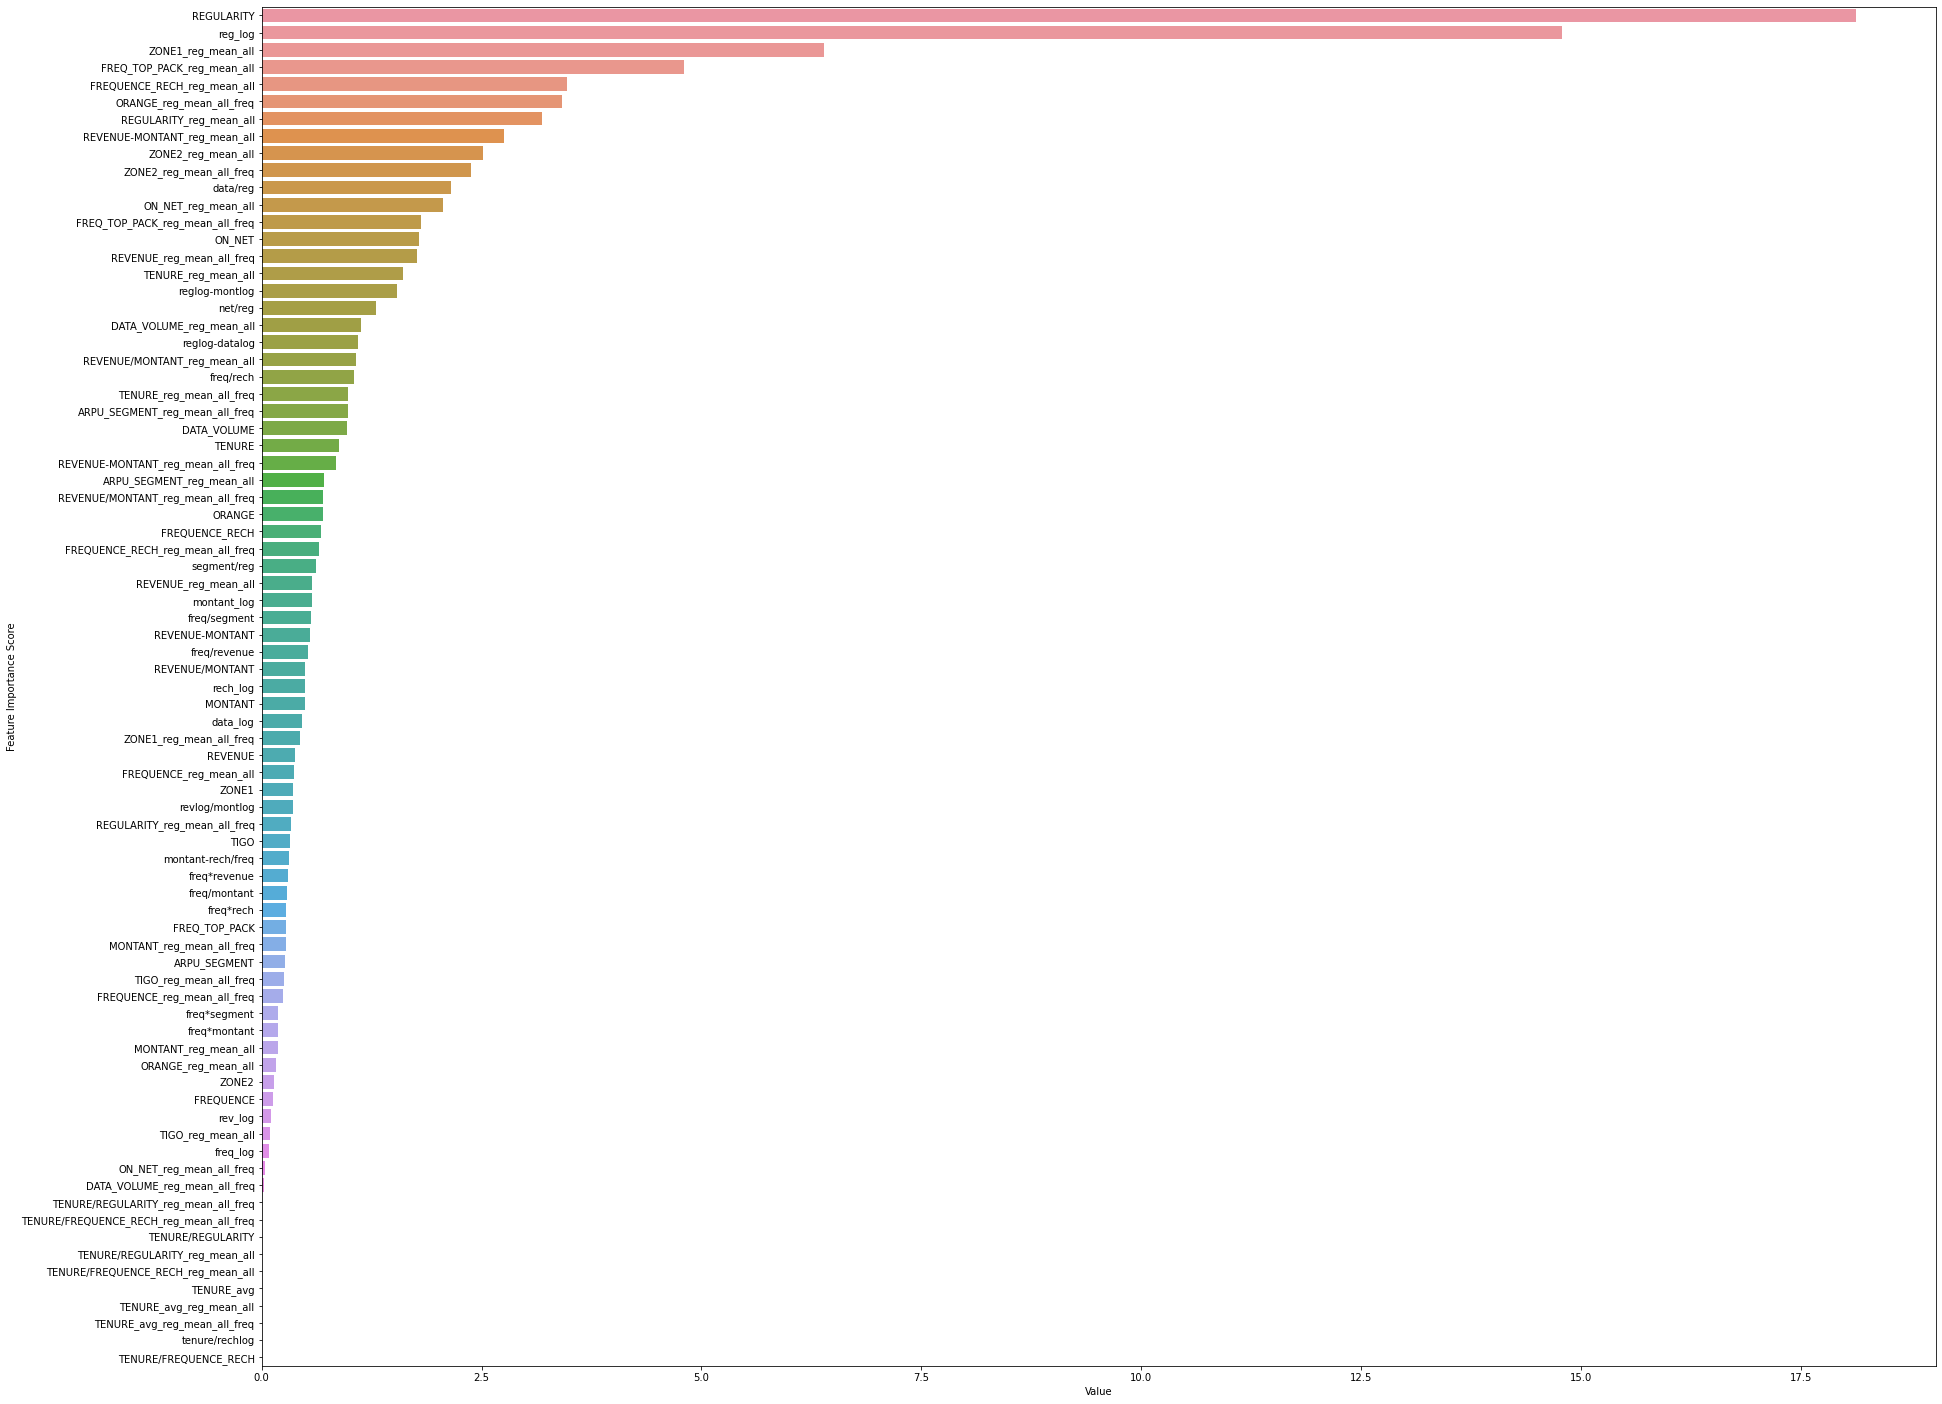

0.9312764473097103 0.9329459047555044 0.00036278354459614426


In [32]:
catboost = cat_.CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='AUC', reg_lambda = 370, task_type="GPU", devices='0:1')
# catboost = cat_.CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='AUC', reg_lambda = 370)

func_= func(train, target, test, catboost, 'catboost', 1000)
val_p1, test_p1, model1 = func_()

### **MODEL 2 - XGBOOST**

To train on CPU, you would have to remove the **tree_method** and **gpu_id** parameters.

================================Fold1====================================
[0]	validation_0-auc:0.891487
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.92136
[2]	validation_0-auc:0.923117
[3]	validation_0-auc:0.923514
[4]	validation_0-auc:0.923617
[5]	validation_0-auc:0.923796
[6]	validation_0-auc:0.924346
[7]	validation_0-auc:0.924589
[8]	validation_0-auc:0.924839
[9]	validation_0-auc:0.924855
[10]	validation_0-auc:0.925129
[11]	validation_0-auc:0.925184
[12]	validation_0-auc:0.925923
[13]	validation_0-auc:0.92644
[14]	validation_0-auc:0.926467
[15]	validation_0-auc:0.926495
[16]	validation_0-auc:0.926895
[17]	validation_0-auc:0.927347
[18]	validation_0-auc:0.927369
[19]	validation_0-auc:0.927708
[20]	validation_0-auc:0.927754
[21]	validation_0-auc:0.928011
[22]	validation_0-auc:0.928041
[23]	validation_0-auc:0.928049
[24]	validation_0-auc:0.928532
[25]	validation_0-auc:0.928548
[26]	validation_0-auc:0.928591
[27]	validation_0-auc:0.929042
[28]	v

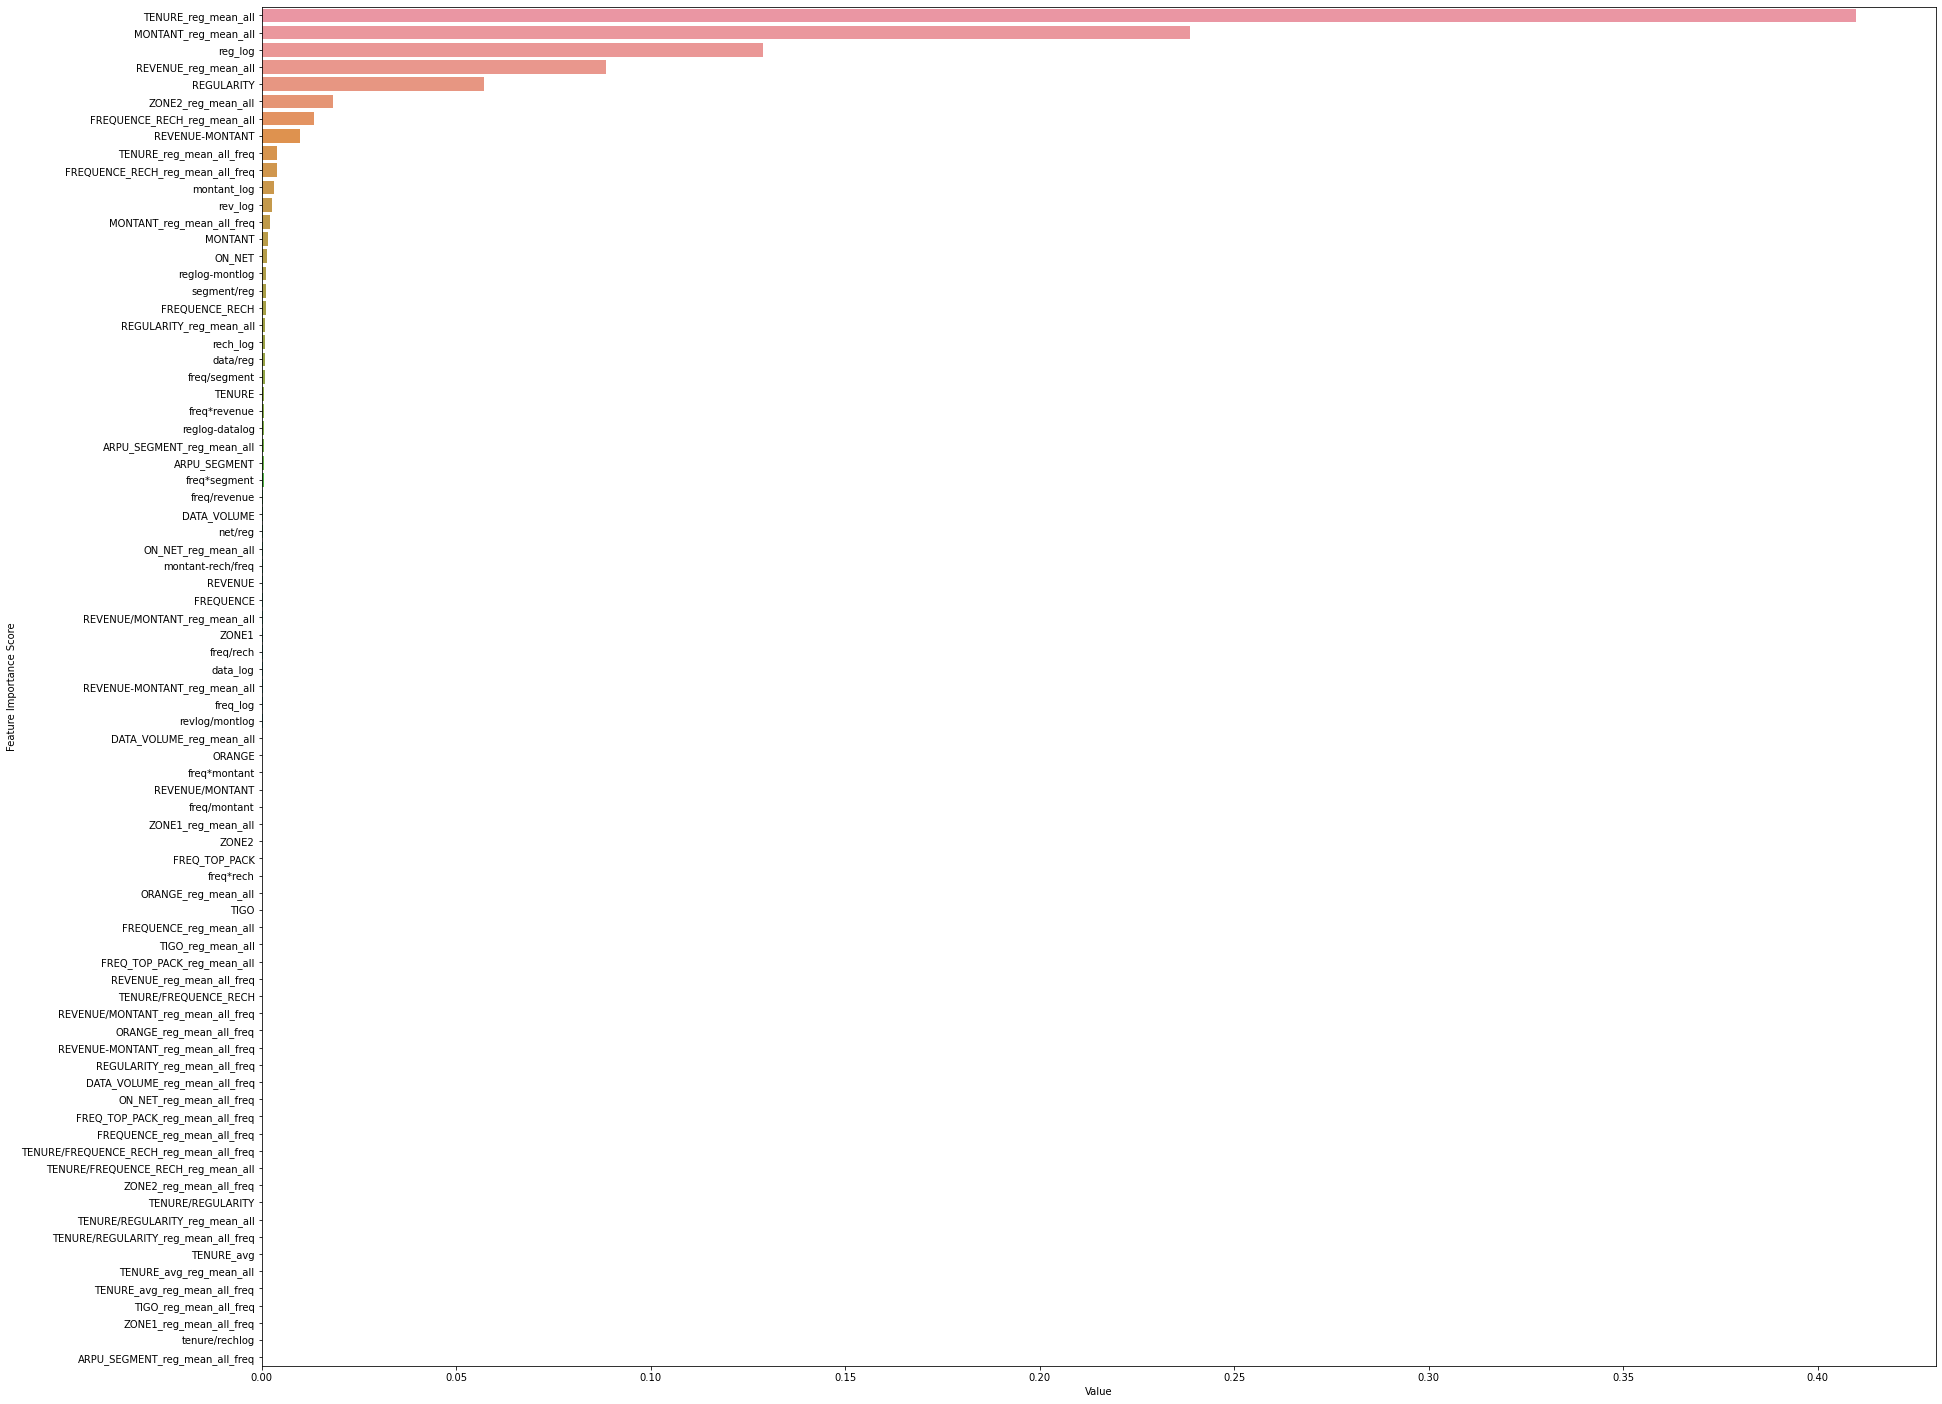

0.9311266010588752 0.9324141629861036 0.0003397570025293023


In [33]:
xgboost = xgb.XGBClassifier(objective ='binary:logistic', 
                          eta = 0.99,
                          max_depth = 6, 
                          n_estimators = 5000,
                          reg_lambda = 500,
                          sub_sample = 0.8,
                          colsample_bytree = 0.8, tree_method='gpu_hist', gpu_id=0)

func_= func(train, target, test, xgboost, 'xgboost', 1000)
val_p2, test_p2, model2 = func_()

### **MODEL 3 - LGBM**

================================Fold1====================================
[1]	valid_0's auc: 0.927169
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.927766
[3]	valid_0's auc: 0.927921
[4]	valid_0's auc: 0.928018
[5]	valid_0's auc: 0.928071
[6]	valid_0's auc: 0.928113
[7]	valid_0's auc: 0.928621
[8]	valid_0's auc: 0.92873
[9]	valid_0's auc: 0.928798
[10]	valid_0's auc: 0.928882
[11]	valid_0's auc: 0.928902
[12]	valid_0's auc: 0.929346
[13]	valid_0's auc: 0.929367
[14]	valid_0's auc: 0.929379
[15]	valid_0's auc: 0.929395
[16]	valid_0's auc: 0.929416
[17]	valid_0's auc: 0.92945
[18]	valid_0's auc: 0.929787
[19]	valid_0's auc: 0.929955
[20]	valid_0's auc: 0.929985
[21]	valid_0's auc: 0.929982
[22]	valid_0's auc: 0.930137
[23]	valid_0's auc: 0.930147
[24]	valid_0's auc: 0.930173
[25]	valid_0's auc: 0.930182
[26]	valid_0's auc: 0.93021
[27]	valid_0's auc: 0.930239
[28]	valid_0's auc: 0.930259
[29]	valid_0's auc: 0.930272
[30]	valid_0's auc: 0.930273
[31]	v

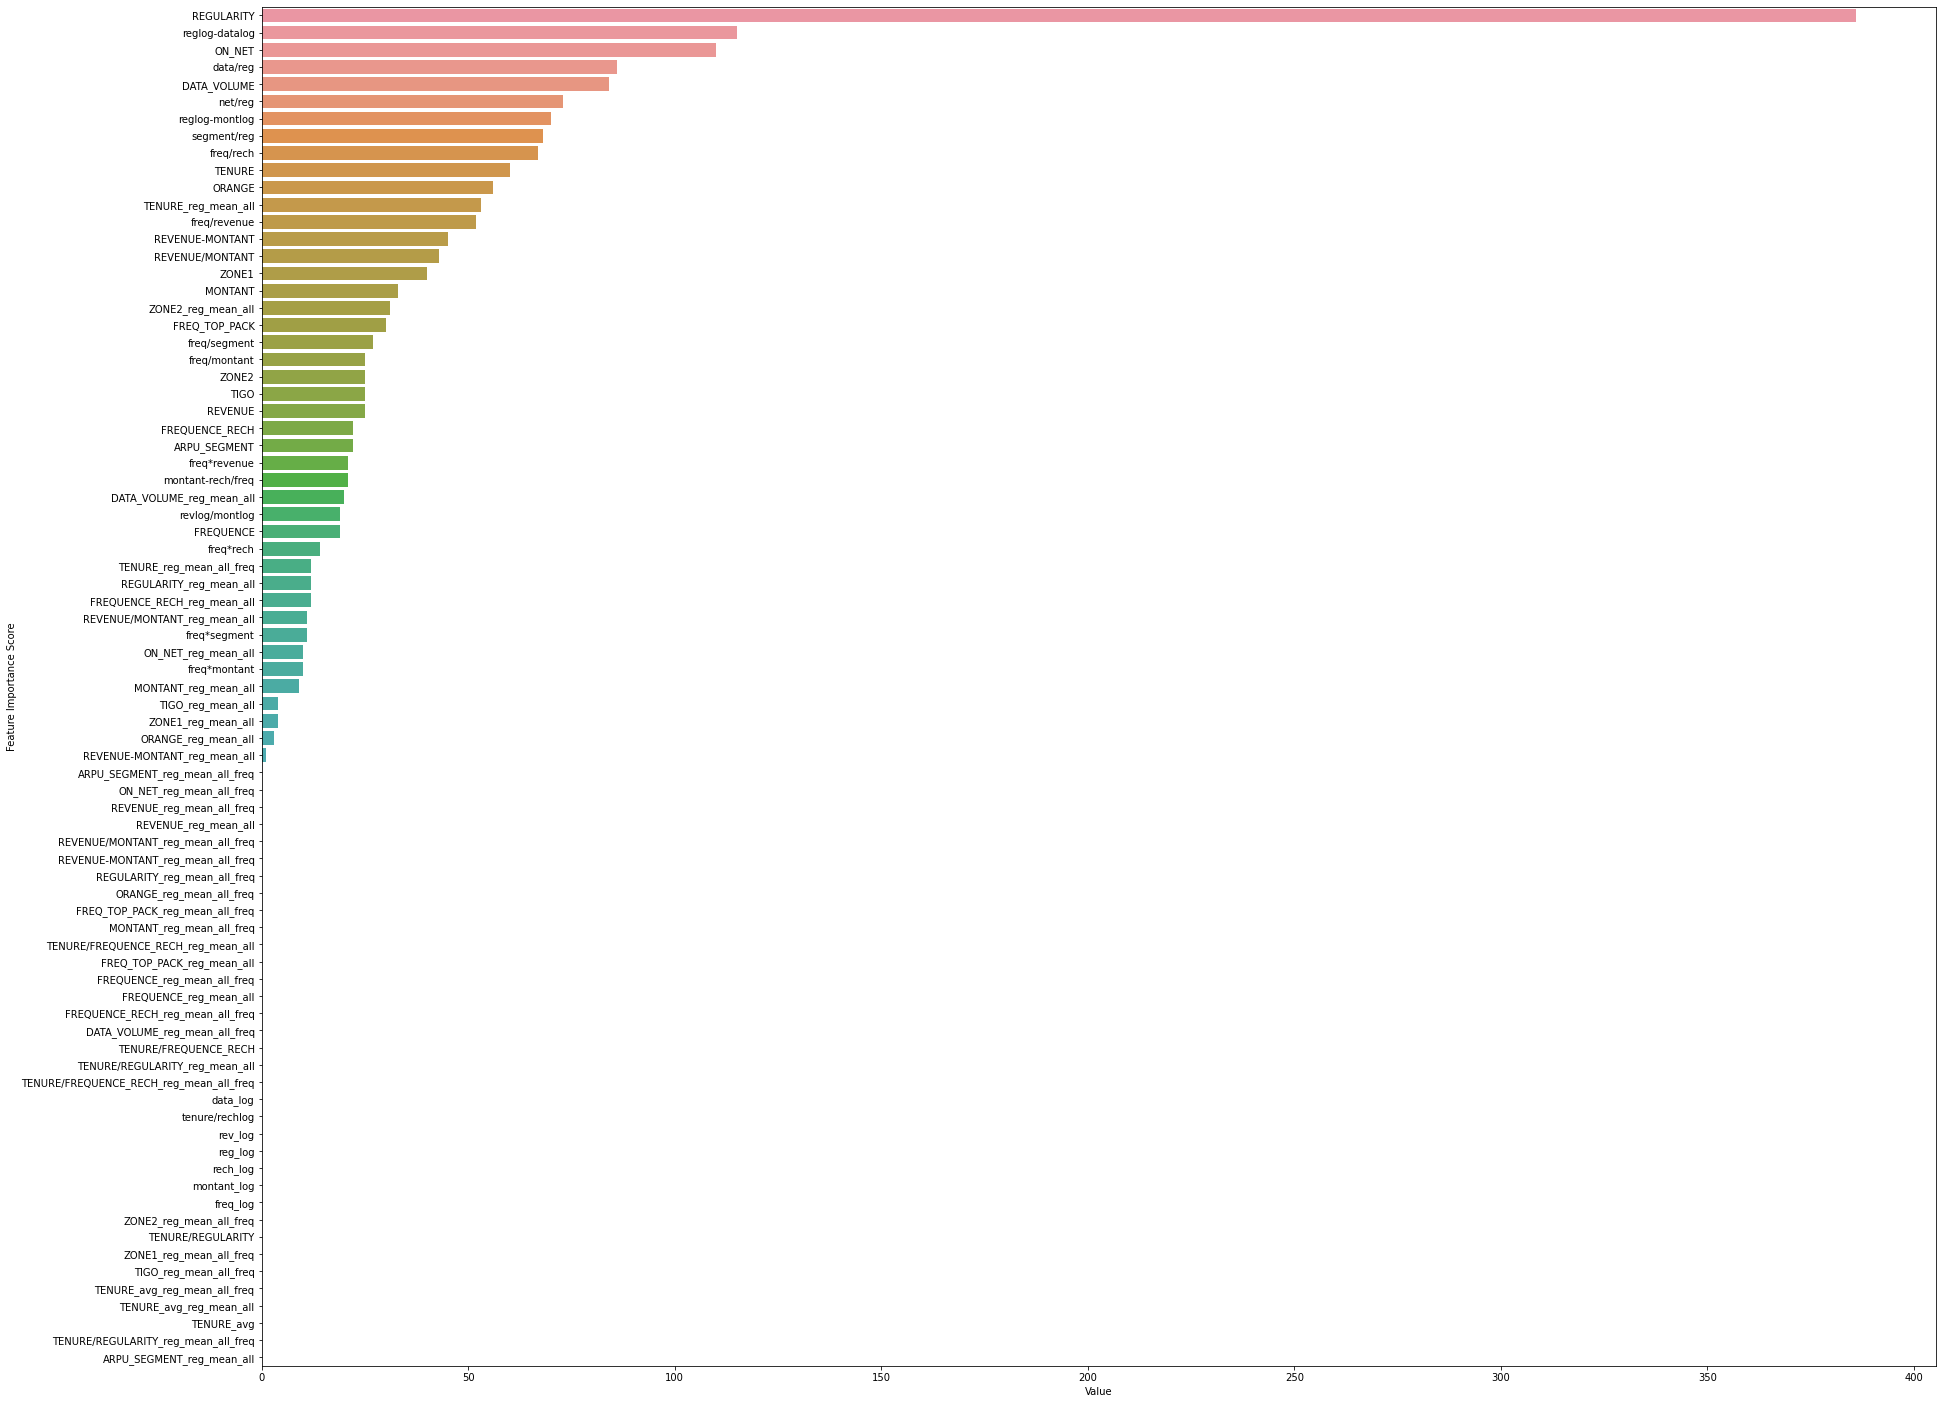

0.9311374437644864 0.9326387465989635 0.00035938765691915137


In [34]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(objective =  'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            lambda_l1= 0.0004912993970392775,
                            lambda_l2= 9.424350138808432,
                            num_leaves= 24,
                            feature_fraction= 1.0,
                            bagging_fraction= 0.9540416539312312,
                            bagging_freq= 7,
                            min_child_samples= 100, n_estimators = 300)

func_= func(train, target, test, lgb_model, 'lgbm', 1000)
val_p3, test_p3, model3 = func_()

### **STACKING**

To stack, we use a simple algorithm as a meta-learner(Linear Regression) to finetune our predictions. We train this algorithm with the predictions of validation sets from all algorithms and use to produce the final predictions with the combination of the test set predictions from all algorithms.

In [35]:
from sklearn.linear_model import  LinearRegression, Ridge, Lasso
stack = np.column_stack((val_p1, val_p2, val_p3))
stack_p = np.column_stack((test_p1, test_p2, test_p3))
predict = LinearRegression().fit(stack, target).predict(stack_p)

### **SUBMISSION**

In [38]:
submission['CHURN'] = predict

submission.to_csv('expersso-churn-prediction/data/solution_stack.csv',index=False)

Final submission with this workflow should give a private leaderboard of 0.24666xxx, This was done by adding the n_estimators parameter for lgbm which was a mistake that wasn't done during the competition.

**FURTHER IMPROVEMENTS**
*   Feauture selection (Backward Elimination).
*   New column for rare values in the TOP_PACK column.
*   Better feature engineering(e.g. amount of missing columns in reach row/ flag if datapoint is missing)
*   Outlier handling
*   Train the different models on different random_seeds so as not to overfit a paticular seed
*   Add different features to different models, etc








